In [3]:
from __future__ import division

%matplotlib inline

import os
import operator
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from utils import *
from skimage import transform, color
from tqdm import tqdm, tqdm_notebook
from keras import initializers

from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

from keras.layers.core import Reshape,Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist

from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam

# share GPU
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 1
# set_session(tf.Session(config=config))

In [29]:
# data constants
max_size = (32, 32)
data_files = {'cifar': '../data/cifar.npy',
              'mnist': '../data/mnist.npy',
              'lfw': '../data/lfw.npy'}

# load and transform data
data = np.load(data_files['lfw'])
data = data.astype('float32')

if data.shape[1:3] > max_size:
    data = np.array([transform.resize(image, max_size, preserve_range=True, order=0) for image in data])
    data = np.array([color.rgb2gray(image) for image in data])[:,:,:,np.newaxis]

# shuffle data
np.random.shuffle(data)

# get data sizes
data_count = data.shape[0]
data_size = data.shape[1:4]
data_dim = reduce(operator.mul, data.shape[1:])

# reshape data if necessary
data = data.reshape(data_count, *data_size)

print 'Loaded data {}'.format(data.shape)

Loaded data (13233, 32, 32, 1)


In [30]:
statistics_axis = 1

data_reshaped = data.reshape(data_count, -1)
data_mean = np.mean(data_reshaped, axis=statistics_axis, keepdims=True, dtype=np.float64)
data_z_mean = (data_reshaped - data_mean)
data_std = np.std(data_z_mean, axis=statistics_axis, keepdims=True, dtype=np.float64) + 1e-16
data_normed = data_z_mean / data_std
data_proc = data_normed.reshape(data_count, *data_size)

print 'Before preproc', data.mean(), data.std()
print 'After preproc', data_proc.mean(), data_proc.std()

Before preproc 95.2502299524 70.6961353529
After preproc 6.15880581166e-18 1.0


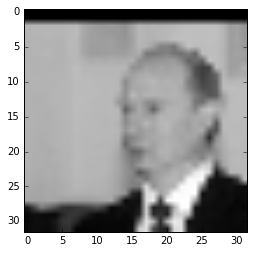

In [56]:
plt.imshow(data_proc[0].reshape(32,32), cmap='gray')
plt.imshow(data[8].reshape(32,32), cmap='gray')
plt.show()

In [57]:
# latent space generators
def get_uniform_space(high, low, space_size):
    return lambda batch_size: np.random.uniform(low, high, (batch_size, space_size)).astype('float32')

def get_gaussian_space(mean, var, space_size):
    return lambda batch_size: np.random.normal(mean, var, (batch_size, space_size)).astype('float32')

In [78]:
def get_conv_model(data_dim, latent_dim):
    # setup optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)

    g_leaky_alpha = 0.1
    d_leaky_alpha = 0.1
    dropout_p = 0.1

    # Generator
    generator = Sequential()
    generator.add(Dense(8*8*128, input_dim=latent_dim, kernel_initializer='random_normal'))
#     generator.add(BatchNormalization())
    generator.add(LeakyReLU(g_leaky_alpha))
    generator.add(Reshape((8,8,128)))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(filters=64,kernel_size=(5,5), padding='same'))
#     generator.add(BatchNormalization(axis=3))
    generator.add(LeakyReLU(g_leaky_alpha))
    generator.add(UpSampling2D(size=(2,2)))
    generator.add(Conv2D(filters=1,kernel_size=(5,5), padding='same', activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=opt)

    # Discriminator
    discriminator = Sequential()
    discriminator.add(Conv2D(filters=64,kernel_size=(5,5), padding='same', strides=(2,2), 
                             input_shape=(32,32,1), kernel_initializer='random_normal'))
#     discriminator.add(BatchNormalization(axis=3))
    discriminator.add(LeakyReLU(d_leaky_alpha))
    discriminator.add(Conv2D(filters=128,kernel_size=(5,5), padding='same', strides=(2,2)))
#     discriminator.add(BatchNormalization(axis=3))
    discriminator.add(LeakyReLU(d_leaky_alpha))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=opt)
#     discriminator.add(Dropout(dropout_p))
        
    # setup combined network
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return (generator, discriminator, gan)

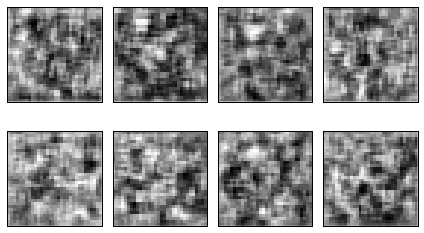

100%|██████████| 103/103 [00:11<00:00,  8.59it/s]


epoch: 0 -- loss G: 0.889613389969 - D: 0.534790635109


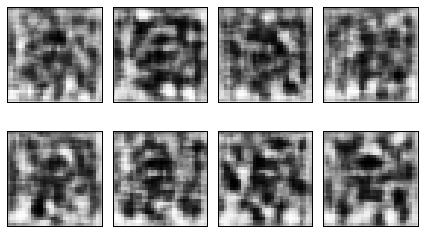

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 1 -- loss G: 3.10545921326 - D: 1.60493397713


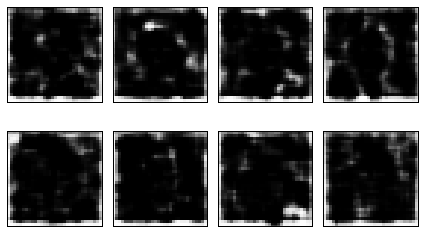

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 2 -- loss G: 1.71721076965 - D: 0.389212965965


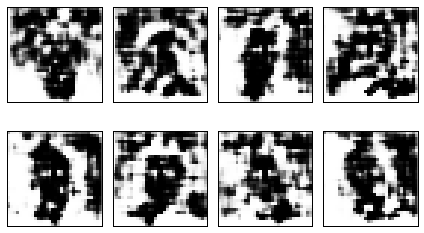

100%|██████████| 103/103 [00:10<00:00, 10.11it/s]


epoch: 3 -- loss G: 1.68692934513 - D: 0.387108147144


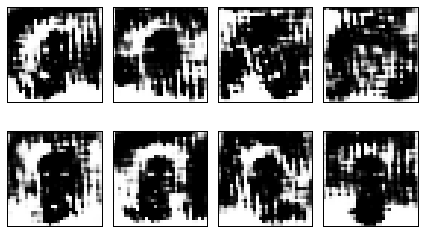

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 4 -- loss G: 2.26405954361 - D: 0.327519893646


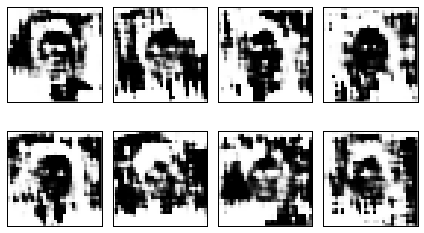

100%|██████████| 103/103 [00:10<00:00, 10.12it/s]


epoch: 5 -- loss G: 2.53266477585 - D: 0.336498647928


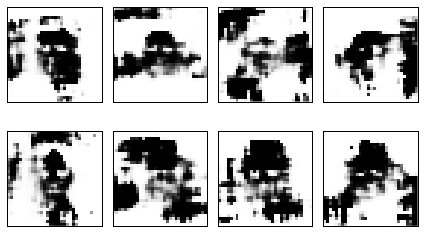

100%|██████████| 103/103 [00:10<00:00, 10.10it/s]


epoch: 6 -- loss G: 2.72008085251 - D: 0.289554238319


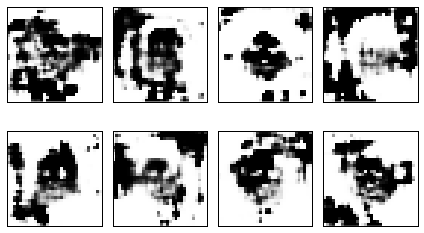

100%|██████████| 103/103 [00:10<00:00, 10.08it/s]


epoch: 7 -- loss G: 3.52472376823 - D: 0.264350295067


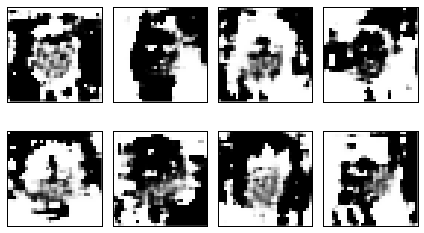

100%|██████████| 103/103 [00:10<00:00, 10.10it/s]


epoch: 8 -- loss G: 3.67153835297 - D: 0.270777821541


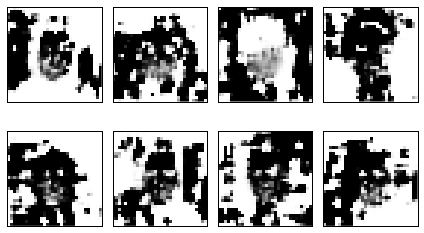

100%|██████████| 103/103 [00:10<00:00, 10.10it/s]


epoch: 9 -- loss G: 3.85724759102 - D: 0.256503105164


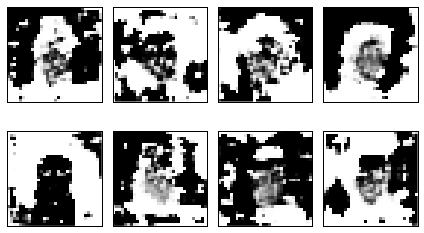

In [79]:
# setup experiment
max_epochs = 10
batch_size = 128
latent_dim = 100
z_space = get_gaussian_space(0, 1, latent_dim)
generator, discriminator, gen_dis = get_conv_model(data_dim, latent_dim)

z_samples = z_space(batch_size).astype('float32')
fakes = generator.predict(z_samples[:8,:])
show_images(fakes, data_size)

# prepare data
dis_labels = np.ones(2*batch_size) * 0.9# np.random.uniform(0.85, 1.0, 2*batch_size)
dis_labels[:batch_size] = 0 
gan_labels = np.ones(batch_size)

g_losses = []
d_losses = []

use_batch_norm = False

for epoch_ix in xrange(max_epochs):
    for batch_ix in tqdm(xrange(0, data_count-batch_size, batch_size)):
        
        if use_batch_norm:
            # train discriminator - true
            discriminator.trainable = True
            x_samples = data_proc[batch_ix: batch_ix+batch_size]
            d_loss_t = discriminator.train_on_batch(
                x_samples, dis_labels[batch_size:])

            # train discriminator - fake
            z_samples = z_space(batch_size).astype('float32')
            d_loss_f = discriminator.train_on_batch(
                generator.predict(z_samples), dis_labels[:batch_size])
            d_loss = (d_loss_t + d_loss_f) / 2
        else:
            discriminator.trainable = True
            x_samples = data_proc[batch_ix: batch_ix+batch_size]
            z_samples = z_space(batch_size).astype('float32')
            d_loss = discriminator.train_on_batch(
                np.vstack((generator.predict(z_samples), x_samples)), dis_labels)

        # train generator
        z_samples = z_space(batch_size).astype('float32')
        discriminator.trainable = False
        g_loss = gen_dis.train_on_batch(z_samples, gan_labels)
        
        # save losses
        g_losses.append(g_loss)
        d_losses.append(d_loss)
    
    print 'epoch: {} -- loss G: {} - D: {}'.format(epoch_ix, 
                                                   g_loss, 
                                                   d_loss)
    z_samples = z_space(batch_size).astype('float32')
    fakes = generator.predict(z_samples[:8,:])
    show_images(fakes, data_size)

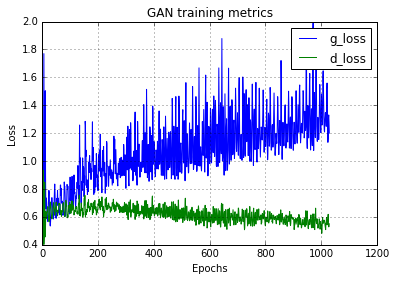

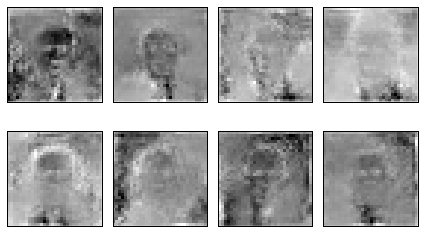

In [75]:
perf_fig = plot_performance(('g_loss', g_losses), ('d_loss', d_losses))
perf_fig.show()
perf_fig.savefig('dcgan-experiments/perf_lat500-alr0_0002-ab10_9-ab20_5-gacttanh-ralpha0_1-dop0_0-bn0-faces-t')

# sample generator
z_samples = z_space(batch_size).astype('float32')
fakes = generator.predict(z_samples[:8,:])
sample_fig = plot_images(fakes, data_size)
sample_fig.show()
perf_fig.savefig('dcgan-experiments/samples_lat500-alr0_0002-ab10_9-ab20_5-gacttanh-ralpha0_1-dop0_0-bn0-faces-t')

In [ ]:
z_samples = z_space(batch_size).astype('float32')
fakes = generator.predict(z_samples[:16])
sample_fig = plot_images(fakes, data_size)